# Using the Crossref API

[Crossref](https://www.crossref.org/) provides an API to get the references of a publication.

https://github.com/CrossRef/rest-api-doc


- A first idea is to go down the references for a fixed number of steps (for example 3), then keep only the articles which have been visited more than N times (for examples 3 times), and draw the upward graph starting from these articles. 
- Second idea: to look a the top cited articles in the creates graph

## to do:
- export the graph to Gephi...

In [188]:
import requests
import time

In [79]:
# used to cache the requested data
requesteddoi = {}

In [123]:
def requestDoi(doi):
    """ Return the data for a given DOI
        - look first in the dictionary requesteddoi
        - if no data send the request to https://api.crossref.org/
    """
    if doi in requesteddoi:
        return requesteddoi[doi]
    else:
        url = 'https://api.crossref.org/works/'
        time.sleep(2)
        params = { 'mailto':'xdze2.me@gmail.com'}
        response = requests.get(url+doi, params=params)
        
        if not response.ok:
            print('query error')
            return None
        else:
            response = response.json()
            message = response['message']
            
            requesteddoi[doi] = message
            return message

In [124]:
def getRefList(doi):
    """ Return the list of reference DOI
    """
    message = requestDoi(doi)
    references = message.get('reference', [])
    referencesWithDoi = { ref['DOI'] for ref in references if 'DOI' in ref }
    # print(doi, len(referencesWithDoi))
    return list( referencesWithDoi )

In [125]:
def printInfo(doi):
    """ Print info about a article
    """
    message = requestDoi(doi)
    doi = message['DOI']
    title = message['title'][0].split(' ')
    if len(title)>8:
        title.insert(8, '\n')
    title = ' '.join( title )
    
    authors = '; '.join( ['{given} {family}'.format( **auth ) for auth in message['author'] ] )
    year = message['issued']['date-parts'][0][0]
    print( "[{DOI}] {title}".format( DOI=message['DOI'], title=title ) )
    print(  authors, '-', message['container-title'][0], '-', year )
    print( 'nbr de refs: ', len(message.get('reference', []) ) )

In [126]:
doi = '10.1063/1.1722034' 
#doi = "10.1063/1.1654632"
#doi = "10.2307/1592274"
printInfo(doi)

[10.1063/1.1722034] Silicon Solar Energy Converters
M. B. Prince - Journal of Applied Physics - 1955
nbr de refs:  4


In [275]:
#  ! pip install graphviz
# https://graphviz.readthedocs.io/en/stable/
# https://graphviz.gitlab.io/_pages/doc/info/attrs.html
from graphviz import Digraph
from IPython.display import Image, display, SVG

In [209]:
class Referencesgraph():
    """ Object to explore the reference graph
        starting from one article 
    """
    
    def __init__(self, doi):
        self.nodes = {doi:{ 'gen':0, 'citedBy':[] } }
        self.len = len( self.nodes )
    
    def grow(self):
        """ Expand the graph by including all the references papers
            i.e. expand one generation
        """
        nodes = self.nodes
        lastGen = self.lastGen()
        lastGenNodes = [ doi for doi, info in nodes.items() if info['gen']==lastGen ]
        
        for i, doi in enumerate( lastGenNodes ):
            print('{}/{} fetch %s'.format( i, len(lastGenNodes), doi ), end='\r')
            references = getRefList(doi)
            
            self.nodes[doi]['refs'] = references
            for ref in references:
                if ref not in self.nodes:
                    self.nodes[ref] = {'gen':lastGen+1, 'citedBy':[doi] }
                else:
                    self.nodes[ref]['citedBy'].append( doi )
                
        print('- done -' + ' '*10 )
        self.len = len( self.nodes )
                   
            
    def lastGen(self):
        """ Number of the last generation of the graph 
        """
        nodes = self.nodes
        return max( n['gen'] for n in nodes.values() )
    
    
    
    def degree(self, node):
        return len( self.nodes[node].get('refs', []) ) + len( self.nodes[node].get('citedBy', []) )
        
        
    def nodesVisitedTwice(self, N=2):
        """ List of nodes visited at least twice (N times)
        """
        isVisitedTwice = lambda node: len(node.get('citedBy', []))>=N
        return [ doi for doi, node in self.nodes.items() if isVisitedTwice(node) ]

        
    def printstats(self):
        print( 'nbre nodes: {}\nlast gen: {}'.format(self.len, self.lastGen() ) )
        

## Create the graph

In [308]:
doi = "10.1063/1.1654632"
doi = "10.1038/s41528-018-0030-4"
refgraph = Referencesgraph(doi)

In [309]:
refgraph.nodes

{'10.1038/s41528-018-0030-4': {'citedBy': [], 'gen': 0}}

In [311]:
refgraph.grow()

refgraph.printstats()

- done -          
nbre nodes: 660
last gen: 2


In [313]:
refgraph.nodesVisitedTwice(N=3)

['10.1038/nmat1215',
 '10.1038/nmat2226',
 '10.1021/nn501732z',
 '10.1038/nnano.2011.184',
 '10.1021/nn4007708',
 '10.1038/nmat3380',
 '10.1021/nl4001053',
 '10.1038/nmat2834',
 '10.1002/adma.201302397',
 '10.1038/nmat2009',
 '10.1126/science.1221561',
 '10.1073/pnas.0502392102',
 '10.1038/nmat1350',
 '10.1126/science.1124005',
 '10.1038/nature12314',
 '10.1021/acsnano.5b00618',
 '10.1073/pnas.0401918101',
 '10.1002/adma.201302240',
 '10.1038/nnano.2008.314',
 '10.1016/j.nanoen.2012.01.004',
 '10.1021/nl300988z',
 '10.1002/adma.201504137',
 '10.1126/science.1250169']

In [314]:
def buildlabel(doi):
    info = requestDoi( doi )
    year = info['issued']['date-parts'][0][0]
    familyname = [ auth['family'] for auth in info['author'] if auth['sequence']=='first'][0]

    key = familyname+str(year)
    return key

In [315]:
# Keep the nodes only cited more than N times
# and the citing articles

nodesToDraw = []
linksToDraw = []
nodesToCheck = refgraph.nodesVisitedTwice(N=4)

while nodesToCheck:
    doi = nodesToCheck.pop()
    nodesToDraw.append(doi)
    
    for citing in refgraph.nodes[doi]['citedBy']:
        
        linksToDraw.append( (doi, citing) )
        if citing not in nodesToDraw and citing not in nodesToCheck:
            nodesToCheck.append( citing )

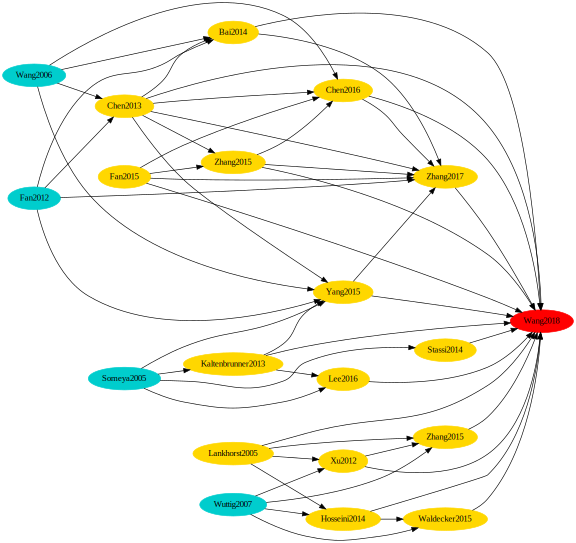

In [316]:
# -- Use Graphviz to draw the graph --
colorGen = ['red', 'gold1', 'cyan3', 'darkorchid2', 'chartreuse2']
# see https://graphviz.gitlab.io/_pages/doc/info/colors.html

DG = Digraph(comment='hello', format='svg', engine='dot' , graph_attr={'size':'8' })#})'root':doi} )
DG.graph_attr['rankdir'] = 'LR'

for doi in nodesToDraw:
    info =  refgraph.nodes[doi]
    DG.node(doi, color=colorGen[info['gen']], style='filled', label= buildlabel(doi))
    
for source, target in linksToDraw:
    DG.edge(source, target)  
            
plt = SVG(DG.render())
display(plt)

## Stats

In [317]:
from collections import Counter

In [318]:
citedByCount = Counter( { doi:len(info['citedBy']) for doi, info in refgraph.nodes.items() } )

In [320]:
for doi, count in citedByCount.most_common(4):
    printInfo( doi )
    print('')

[10.1002/adma.201302397] Harmonic-Resonator-Based Triboelectric Nanogenerator as a Sustainable Power Source 
 and a Self-Powered Active Vibration Sensor
Jun Chen; Guang Zhu; Weiqing Yang; Qingshen Jing; Peng Bai; Ya Yang; Te-Chien Hou; Zhong Lin Wang - Advanced Materials - 2013
nbr de refs:  31

[10.1038/nmat1350] Low-cost and nanoscale non-volatile memory concept for future 
 silicon chips
Martijn H. R. Lankhorst; Bas W. S. M. M. Ketelaars; R. A. M. Wolters - Nature Materials - 2005
nbr de refs:  16

[10.1073/pnas.0502392102] Conformable, flexible, large-area networks of pressure and thermal 
 sensors with organic transistor active matrixes
T. Someya; Y. Kato; T. Sekitani; S. Iba; Y. Noguchi; Y. Murase; H. Kawaguchi; T. Sakurai - Proceedings of the National Academy of Sciences - 2005
nbr de refs:  17

[10.1126/science.1124005] Piezoelectric Nanogenerators Based on Zinc Oxide Nanowire Arrays
Z. L. Wang - Science - 2006
nbr de refs:  0



## Draft

In [192]:
import networkx as nx

G = nx.DiGraph()
for source, target in AllGenRefs:
    
    if outDegree[source]>0:
        G.add_edge(source, target) 

nx.drawing.draw(G) 

NameError: name 'AllGenRefs' is not defined